# Comparing Random vs Non Random data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds
from hard_rules import denoised_fraction, version_serializtion
from lots import longest_sequence, plot_intervals

In [4]:
data = pd.read_parquet("../Data/random_10k.parquet")

In [5]:
data = data[data["maid"]=='7']

## Filtering
1. Non houses 
2. Cookies with mixed constant 
3. Cookies which are assigned to a house which they do not apepar in

In [6]:
data = data[~data['is_hh']]

In [7]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [8]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [9]:
equal_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

In [10]:
mixed_iiqids = more_than_5.index.get_level_values(level=1).to_list()

In [11]:
data = data[~data['iiqid'].isin(mixed_iiqids)]

In [12]:
misplaced_series = ~data.groupby('iiqid')['is_house_ip_or_source_ip'].any()
misplaced_iiqids = misplaced_series[misplaced_series].index.values

In [13]:
data = data[~data['iiqid'].isin(misplaced_iiqids)]

## Creating relevant tables
- Random pairs
- Cookies time data
- Cookies version noise data

In [14]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [15]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [16]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [17]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [18]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [19]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [20]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [21]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [22]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [23]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [24]:
cookie_time = data.groupby('iiqid')['time'].agg(['min', 'max'])

In [25]:
cookie_time['interval'] = (cookie_time['max'] - cookie_time['min']).apply(lambda t: t.days)

In [26]:
noises = data.groupby('iiqid').apply(denoised_fraction)

In [27]:
noises = noises.rename('noise')

### A single pair

- Time interval first
- Time interval second
- Time between end first and start second(maybe after remove outliers)
- Time interval we looked at (can check options)
- Number of points min
- Number of points max
- UA version error
- Overlap errors that we calculate

In [28]:
random_cookie_1 = np.random.choice(data['iiqid'].unique())
random_cookie_2 = np.random.choice(data['iiqid'].unique())

In [29]:
size1 = len(data[data['iiqid']==random_cookie_1])
size2 = len(data[data['iiqid']==random_cookie_2])

In [30]:
single_row = pd.DataFrame({'id1': [random_cookie_1], 'id2': [random_cookie_2], 
              'min_size': min(size1, size2), 'max_size':max(size1, size2)})

In [31]:
single_row = single_row.merge(cookie_time, left_on='id1', right_index=True)
single_row = single_row.merge(cookie_time, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [32]:
single_row = single_row.merge(noises, left_on='id1', right_index=True)
single_row = single_row.merge(noises, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [33]:
single_row

id1         id2  min_size  max_size                 min_id1  \
0  EpSAKWQ0mr  mE4HhnNhcm         1         8 2023-02-24 15:15:58.281   

                  max_id1  interval_id1                 min_id2  \
0 2023-02-24 15:15:58.281             0 2023-02-07 22:43:03.050   

                  max_id2  interval_id2  noise_id1  noise_id2  
0 2023-02-08 11:31:55.767             0        1.0        1.0

### Random Data

In [34]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/1330 [00:00<?, ?it/s]

In [35]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [36]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [37]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [38]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [39]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [40]:
random_trial_data.describe().transpose()

count       mean         std       min        25%        50%  \
merge_noise     1330.0   0.129195    0.140829  0.000000   0.010753   0.071429   
size_0          1330.0  41.502256   77.614521  1.000000   2.000000  12.000000   
size_1          1330.0  43.998496   94.699708  1.000000   2.000000  12.000000   
interval_0      1330.0  34.860150   33.214876  0.000000   0.000000  29.000000   
interval_1      1330.0  35.977444   33.210111  0.000000   0.000000  30.000000   
vers_clean_0    1330.0   0.998292    0.013782  0.666667   1.000000   1.000000   
vers_clean_1    1330.0   0.998163    0.015096  0.666667   1.000000   1.000000   
min_size        1330.0  12.679699   25.628144  1.000000   1.000000   3.000000   
max_size        1330.0  72.821053  111.930839  1.000000  10.000000  37.000000   
min_interval    1330.0  18.221805   25.960576  0.000000   0.000000   0.000000   
max_interval    1330.0  52.615789   30.674002  0.000000  28.000000  62.000000   
min_vers_clean  1330.0   0.996530    0.020268  0.666667   1.000000   1.000000   
max_vers_clean  1330.0   0.999925    0.001145  0.967213   1.000000   1.000000   

                      75%     max  
merge_noise      0.219878     0.5  
size_0          47.750000   875.0  
size_1          46.000000  1441.0  
interval_0      69.000000    88.0  
interval_1      71.000000    88.0  
vers_clean_0     1.000000     1.0  
vers_clean_1     1.000000     1.0  
min_size        13.000000   275.0  
max_size        89.750000  1441.0  
min_interval    32.000000    87.0  
max_interval    80.000000    88.0  
min_vers_clean   1.000000     1.0  
max_vers_clean   1.000000     1.0

<AxesSubplot: >

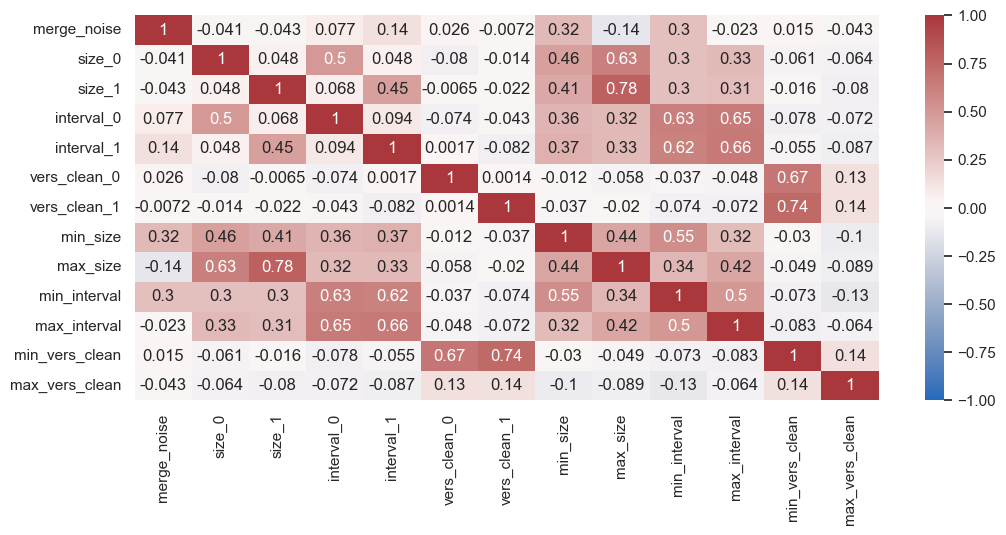

In [41]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [42]:
# mins = random_trial_data[features].min()
# maxs = random_trial_data[features].max()

In [43]:
# random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1), 'merge_noise'].mean()

In [44]:
# matrix = []
# for s in range(1, 30):
#     row = []
#     for i in range(14):
#         row.append(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1), 
#                                          'merge_noise'].mean())
#     matrix.append(row)

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [45]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [46]:
# features
thresholds = [3, 7, 0.5]
noise_thresh = 0.02

In [47]:
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.07735849056603773


In [48]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

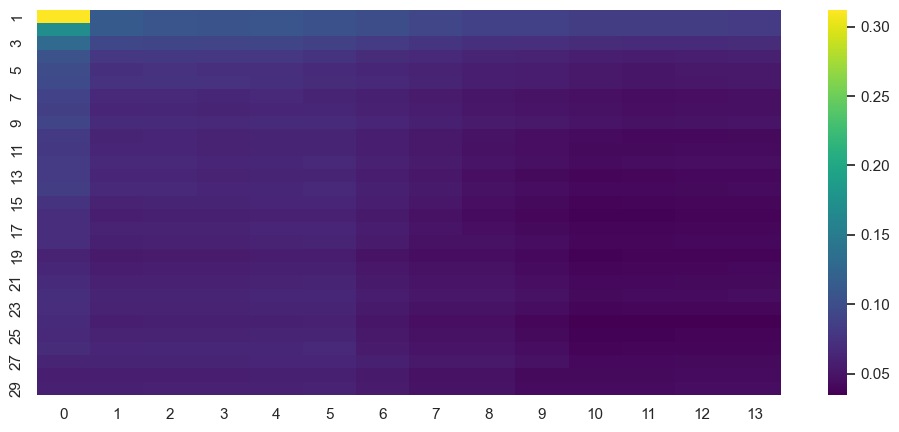

In [49]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

## Non-Random Data

In [50]:
more_than_one_cooke = data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [51]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2, replace=False)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [52]:
brothers_paris = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_paris.columns = ['first','second']

In [53]:
i = 0
iiqid_0, iiqid_1 = trial_pairs.iloc[i].values
print(iiqid_0, iiqid_1)

MONnq4JN4P T9zwT1qFhM


In [54]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for i in tqdm(brothers_paris.index):
    iiqid_0, iiqid_1 = brothers_paris.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/2627 [00:00<?, ?it/s]

In [55]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [56]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [57]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [58]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [59]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [60]:
random_trial_data2.describe().transpose()

count       mean        std       min       25%        50%  \
merge_noise     2627.0   0.146835   0.155190  0.000000  0.008197   0.090909   
size_0          2627.0  34.397031  69.331057  1.000000  2.000000  10.000000   
size_1          2627.0  37.492196  77.736413  1.000000  2.000000  10.000000   
interval_0      2627.0  28.043776  30.978212  0.000000  0.000000  15.000000   
interval_1      2627.0  28.719071  31.388451  0.000000  0.000000  16.000000   
vers_clean_0    2627.0   0.998295   0.016744  0.588235  1.000000   1.000000   
vers_clean_1    2627.0   0.997727   0.020412  0.500000  1.000000   1.000000   
min_size        2627.0  13.022459  27.130525  1.000000  1.000000   3.000000   
max_size        2627.0  58.866768  95.221959  1.000000  8.000000  25.000000   
min_interval    2627.0  15.805101  24.138265  0.000000  0.000000   0.000000   
max_interval    2627.0  40.957746  32.342055  0.000000  6.000000  41.000000   
min_vers_clean  2627.0   0.996192   0.026052  0.500000  1.000000   1.000000   
max_vers_clean  2627.0   0.999831   0.003439  0.866667  1.000000   1.000000   

                  75%     max  
merge_noise      0.25     0.5  
size_0          36.00  1042.0  
size_1          38.00  1573.0  
interval_0      55.00    88.0  
interval_1      57.00    88.0  
vers_clean_0     1.00     1.0  
vers_clean_1     1.00     1.0  
min_size        13.00   590.0  
max_size        73.00  1573.0  
min_interval    26.00    88.0  
max_interval    74.00    88.0  
min_vers_clean   1.00     1.0  
max_vers_clean   1.00     1.0

In [61]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

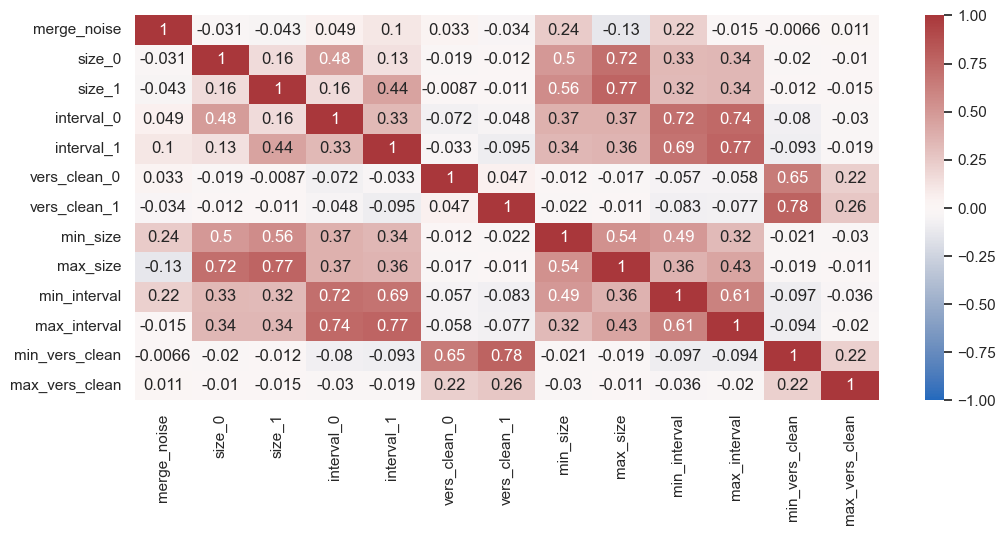

In [62]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [63]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [64]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

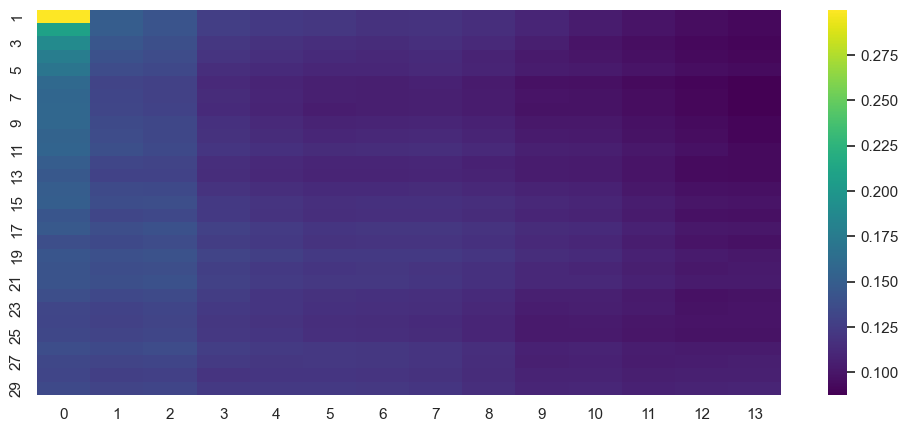

In [65]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

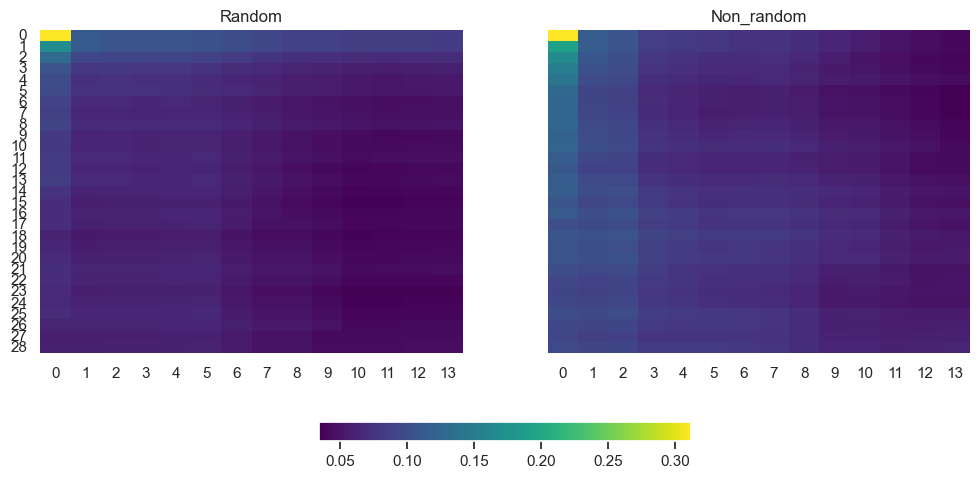

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [67]:
matrix_part = [m[:10] for m in matrix[:10]]
matrix2_part = [m[:10] for m in matrix2[:10]]

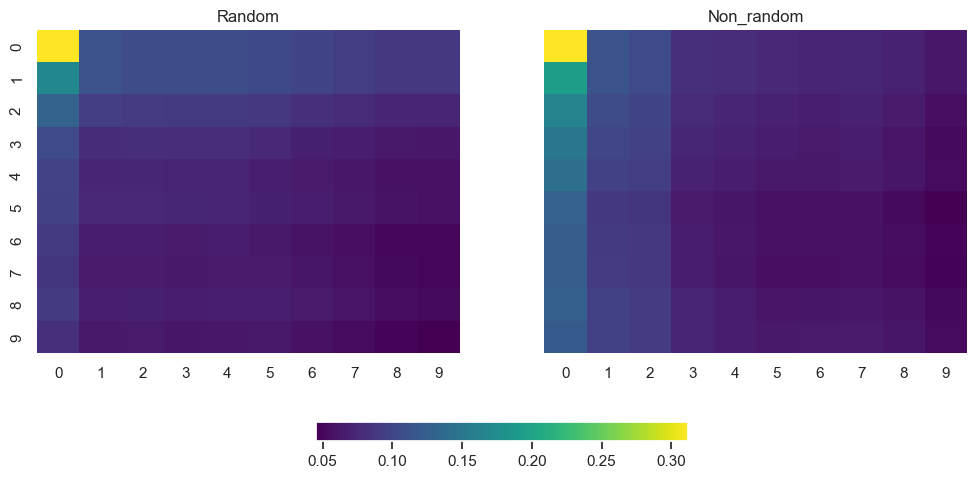

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix_part, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2_part, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [69]:
s = 20
i = 14
len(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)])

195

In [70]:
matrix_test = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(total_above_thresh))
    matrix_test.append(row)

In [71]:
min(min(matrix_test))

258

Text(0.5, 1.0, 'Non-Random')

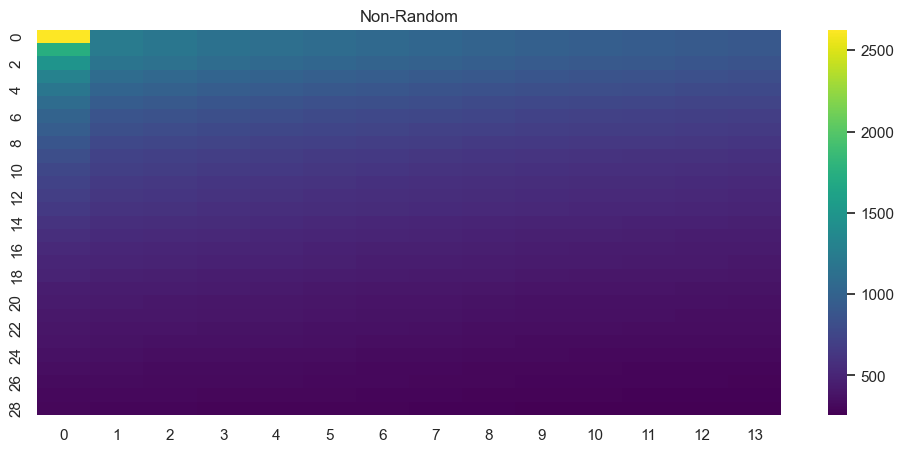

In [72]:
sns.heatmap(matrix_test, cmap='viridis')
plt.title("Non-Random")

## GridSearch

In [73]:
def good_cookies_above_thresh(df, min_interval, min_size, min_vers_clean, merge_noise):
    total_above_thresh = df.loc[(df[features] >= [min_size, min_interval, min_vers_clean]).all(axis=1)]
    good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < merge_noise]
    return len(good_aobve_thresh)/len(total_above_thresh)

In [74]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize variables to keep track of the best parameter values and the largest difference
best_diff_params = None
best_ratio_params = None
largest_difference = None
largest_ratio = None

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0
    
    # Check if the current parameter values give a larger difference than the previous best
    if largest_difference is None or difference > largest_difference:
        largest_difference = difference
        best_diff_params = param_values

    if largest_ratio is None or ratio > largest_ratio:
        largest_ratio = ratio
        best_ratio_params = param_values

# Print the best parameter values and the largest difference
print("Best difference parameters:", {k: round(v, 3) for k,v in best_diff_params.items()})
print("Largest difference:", largest_difference)
print("Best ratio parameters:", {k: round(v, 3) for k,v in best_ratio_params.items()})
print("Largest ratio:", largest_ratio)

  0%|          | 0/5000 [00:00<?, ?it/s]

Best difference parameters: {'min_interval': 11, 'min_size': 5, 'min_vers_clean': 1.0, 'merge_noise': 0.14}
Largest difference: 0.07930853489592743
Best ratio parameters: {'min_interval': 11, 'min_size': 7, 'min_vers_clean': 0.944, 'merge_noise': 0.02}
Largest ratio: 0.5450928381962865


In [75]:
result_diff = {k: round(v, 3) for k,v in best_diff_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_diff_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_diff_params)
pd.DataFrame(result_diff, index=['best'])

min_interval  min_size  min_vers_clean  merge_noise    random  \
best            11         5             1.0         0.14  0.338109   

      non-random  
best    0.417417

In [76]:
result_diff = {k: round(v, 3) for k,v in best_ratio_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_ratio_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_ratio_params)
pd.DataFrame(result_diff, index=['best'])

min_interval  min_size  min_vers_clean  merge_noise   random  non-random
best            11         7           0.944         0.02  0.04244    0.093294

In [77]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [78]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [79]:
results_df.sort_values(by='ratio', ascending=False).head(10)

min_interval  min_size  min_vers_clean  merge_noise    random  \
3867            11         7        0.944444         0.02  0.042440   
3553            10         8        0.944444         0.02  0.044944   
247             11         7        0.666667         0.02  0.044271   
1937            11         7        0.611111         0.02  0.044271   
441             11         7        0.555556         0.02  0.044271   
4767            11         7        0.500000         0.02  0.044271   
235             11         8        0.611111         0.02  0.044693   
1949            11         8        0.555556         0.02  0.044693   
2771            11         8        0.500000         0.02  0.044693   
1405             1         8        0.944444         0.02  0.062500   

      non-random  difference     ratio  
3867    0.093294    0.050854  0.545093  
3553    0.097117    0.052173  0.537219  
247     0.094901    0.050630  0.533504  
1937    0.094901    0.050630  0.533504  
441     0.094633    0.050362  0.532183  
4767    0.094499    0.050228  0.531522  
235     0.094955    0.050263  0.529330  
1949    0.094815    0.050122  0.528631  
2771    0.094675    0.049982  0.527933  
1405    0.132335    0.069835  0.527712

<AxesSubplot: >

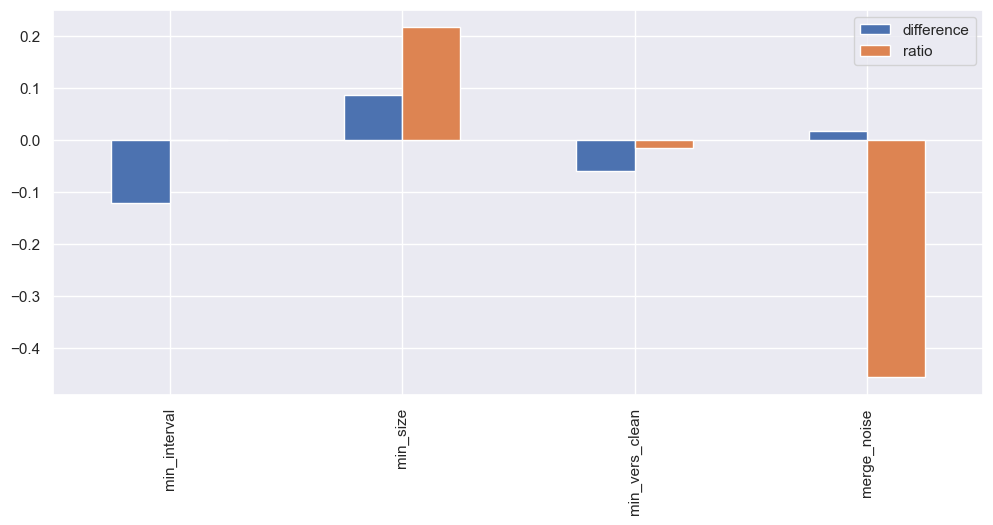

In [80]:
results_df.corr()[['difference', 'ratio']][:4].plot.bar()

## Restrict by longest living cookie

### LOTS

In [81]:
df = cookie_time.head(15).reset_index().sort_values(by='min')

In [82]:
longest_sequence(cookie_time.sample(15).reset_index(), name_str='iiqid', start_str='min', end_str='max')

['6udjlgQKwe', '2b3RVvsQvY']

In [83]:
shots = cookie_time[(5 < cookie_time['interval']) & (cookie_time['interval'] < 20)].reset_index()

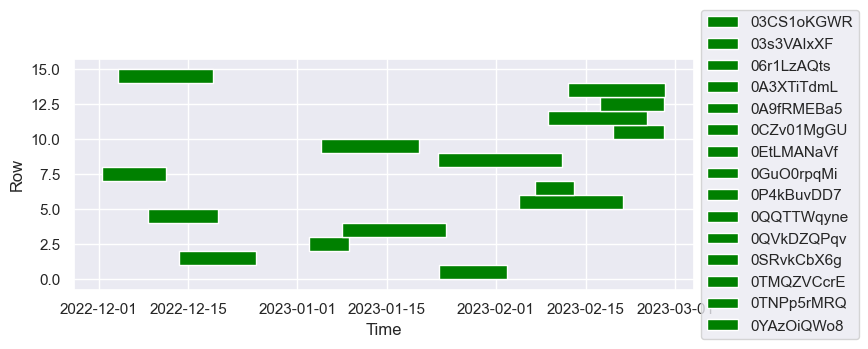

In [84]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green')

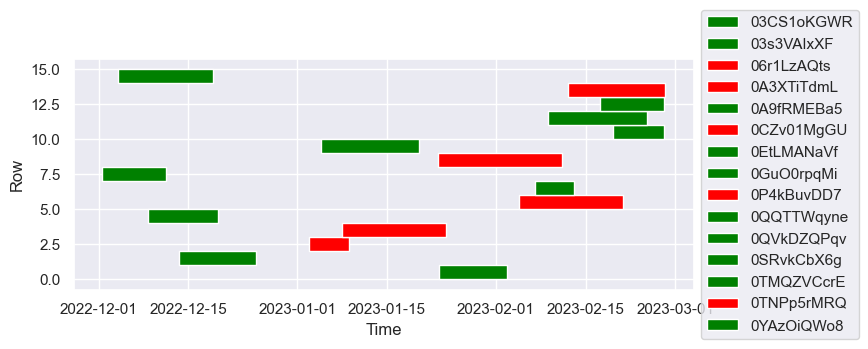

In [85]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green', highlight_ids=chosen_ids, highlight_color='red')

In [154]:
def longest_sequence_range(data, name_str='id', start_str='start', end_str='end'):
    chosen_ids = longest_sequence(data, name_str=name_str, start_str=start_str, end_str=end_str)
    starting_point = data.loc[data[name_str].isin(chosen_ids), start_str].min()
    ending_point = data.loc[data[name_str].isin(chosen_ids), end_str].max()
    return starting_point, ending_point

In [155]:
longest_sequence_range(df, name_str='iiqid', start_str='min', end_str='max')

(Timestamp('2023-01-02 20:49:59.663000'),
 Timestamp('2023-02-27 10:54:08.877000'))

In [152]:
print(df.loc[df['iiqid'].isin(chosen_ids), 'min'].min())
print(df.loc[df['iiqid'].isin(chosen_ids), 'max'].max())

2023-01-02 20:49:59.663000
2023-02-27 10:54:08.877000


### Filtering

In [86]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [87]:
cookies_data = cookie_time.reset_index().merge(data[const+['iiqid']], on='iiqid', how='left')

In [88]:
longest_cookie_per_home = cookies_data.groupby('hh_id').apply(lambda h: h.loc[h['interval'].idxmax(), 'iiqid'])

In [89]:
longest_cookie_per_home.name = 'iiqid'

In [90]:
longest_cookie_per_home_data = pd.merge(longest_cookie_per_home.reset_index(), cookies_data, 
                                        on=['hh_id', 'iiqid'], how='inner')
longest_cookie_per_home_data = longest_cookie_per_home_data.drop_duplicates()

In [91]:
cookie_vs_longest = cookies_data.merge(longest_cookie_per_home_data, on='hh_id', suffixes=[None, '_longest'])

In [92]:
filtered_cookies = cookie_vs_longest[(((cookie_vs_longest['min'] < cookie_vs_longest['min_longest'])
                                       & (cookie_vs_longest['max'] > cookie_vs_longest['min_longest']))
                                      | ((cookie_vs_longest['min'] > cookie_vs_longest['min_longest'])
                                         & (cookie_vs_longest['min'] < cookie_vs_longest['max_longest'])))]

In [93]:
filtered_cookies = filtered_cookies.drop_duplicates()

In [94]:
filtered_data = data[data['iiqid'].isin(filtered_cookies['iiqid'].values.tolist())]

#### Random

In [95]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [96]:
filtered = filtered_data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [97]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [98]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [99]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [100]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [101]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [102]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [103]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [104]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'time_diff': [], 'first' : [], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
    pair_time_diff = abs(iiqid_0_start - iiqid_1_start)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['time_diff'].append(pair_time_diff)
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/886 [00:00<?, ?it/s]

In [105]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [106]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [107]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [108]:
random_trial_data.head(1)

merge_noise  size_0  size_1               time_diff       first  \
0          0.0      77       6 27 days 09:33:45.099000  IUjkGRKgxd   

       second                   min_0                   max_0  interval_0  \
0  gUlQWbXrL9 2022-12-02 09:48:10.154 2022-12-10 18:00:06.486           8   

                    min_1                   max_1  interval_1  noise_0  \
0 2022-12-29 19:21:55.253 2023-02-25 15:19:25.288          57      1.0   

   noise_1  min_size  max_size  
0      1.0         6        77

In [109]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [110]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [111]:
random_trial_data['days_diff'] = random_trial_data.time_diff.apply(lambda t: t.days)

In [112]:
random_trial_data.describe().transpose()

count                        mean                         std  \
merge_noise     886.0                    0.138732                    0.141661   
size_0          886.0                   36.211061                    70.90332   
size_1          886.0                   34.802483                   64.938514   
time_diff         886  26 days 09:47:26.730241535  21 days 02:10:49.650197735   
interval_0      886.0                   32.802483                    30.09605   
interval_1      886.0                   32.389391                   30.600555   
vers_clean_0    886.0                    0.997623                    0.020889   
vers_clean_1    886.0                    0.998311                    0.012076   
min_size        886.0                   10.957111                   23.290656   
max_size        886.0                   60.056433                   86.579999   
min_interval    886.0                   17.226862                   23.758184   
max_interval    886.0                   47.965011                   28.369872   
min_vers_clean  886.0                    0.995959                    0.023954   
max_vers_clean  886.0                    0.999975                    0.000738   
days_diff       886.0                   25.943567                   21.086027   

                                   min                     25%  \
merge_noise                        0.0                0.019706   
size_0                             1.0                     3.0   
size_1                             1.0                     3.0   
time_diff       0 days 00:20:27.312000  8 days 09:35:18.645250   
interval_0                         0.0                     0.0   
interval_1                         0.0                     0.0   
vers_clean_0                  0.588235                     1.0   
vers_clean_1                       0.8                     1.0   
min_size                           1.0                     1.0   
max_size                           1.0                    12.0   
min_interval                       0.0                     0.0   
max_interval                       0.0                    25.0   
min_vers_clean                0.588235                     1.0   
max_vers_clean                0.978022                     1.0   
days_diff                          0.0                     8.0   

                                    50%                      75%  \
merge_noise                    0.087977                 0.231988   
size_0                             12.0                    38.75   
size_1                             11.0                    36.75   
time_diff       21 days 09:03:51.789000  39 days 17:18:15.209000   
interval_0                         28.0                     59.0   
interval_1                         26.0                    61.75   
vers_clean_0                        1.0                      1.0   
vers_clean_1                        1.0                      1.0   
min_size                            4.0                     11.0   
max_size                           29.0                     74.0   
min_interval                        3.0                     29.0   
max_interval                       52.0                     75.0   
min_vers_clean                      1.0                      1.0   
max_vers_clean                      1.0                      1.0   
days_diff                          21.0                     39.0   

                                    max  
merge_noise                         0.5  
size_0                           1042.0  
size_1                            545.0  
time_diff       85 days 22:47:06.658000  
interval_0                         87.0  
interval_1                         88.0  
vers_clean_0                        1.0  
vers_clean_1                        1.0  
min_size                          362.0  
max_size                         1042.0  
min_interval                       87.0  
max_interval                       88.0  
min_vers_clean             

<AxesSubplot: >

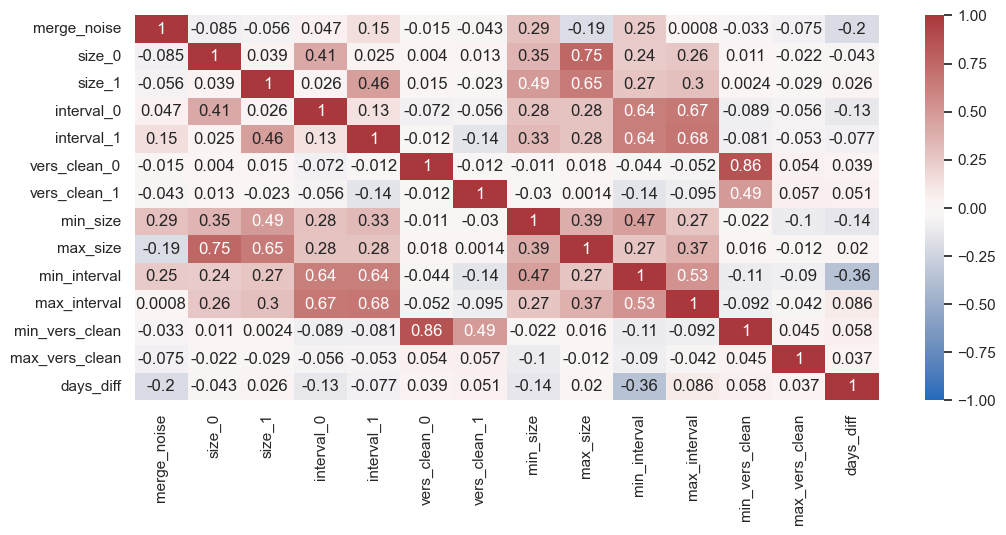

In [113]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [114]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [115]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

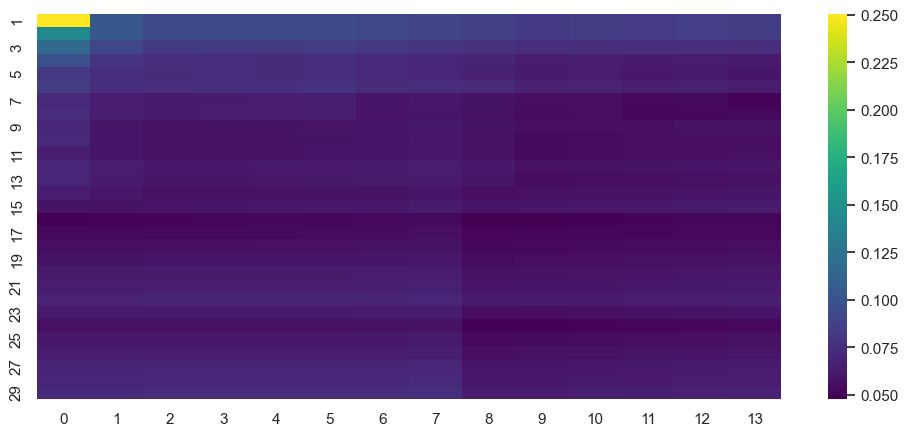

In [116]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

#### Non-Random

In [117]:
more_than_one_cooke = filtered_data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [118]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2, replace=False)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [119]:
brothers_pairs = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_pairs.columns = ['first','second']

In [120]:
i = 3
iiqid_0, iiqid_1 = brothers_pairs.iloc[i].values
pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                    | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
pair_data.sort_values(by='time', inplace=True)
iiqid_0, iiqid_1
# iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
# print(iiqid_0_start, iiqid_1_start)
# pair_time_diff = abs(iiqid_0_start - iiqid_1_start)

('hYVQGjvJGM', 'JvxMvUw8UX')

In [121]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'time_diff': [], 'first' : [], 'second': []}

for i in tqdm(brothers_pairs.index):
    iiqid_0, iiqid_1 = brothers_pairs.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
    pair_time_diff = abs(iiqid_0_start - iiqid_1_start)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['time_diff'].append(pair_time_diff)    
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/1734 [00:00<?, ?it/s]

In [122]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [123]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [124]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [125]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [126]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [127]:
random_trial_data2['days_diff'] = random_trial_data2.time_diff.apply(lambda t: t.days)

In [128]:
random_trial_data2.describe().transpose()

count                        mean  \
merge_noise     1734.0                    0.152341   
size_0          1734.0                   26.509227   
size_1          1734.0                   30.890427   
time_diff         1734  23 days 21:42:37.248409457   
interval_0      1734.0                   23.629758   
interval_1      1734.0                   25.786621   
vers_clean_0    1734.0                    0.999105   
vers_clean_1    1734.0                    0.997731   
min_size        1734.0                   10.956171   
max_size        1734.0                   46.443483   
min_interval    1734.0                   13.369666   
max_interval    1734.0                   36.046713   
min_vers_clean  1734.0                    0.996842   
max_vers_clean  1734.0                    0.999994   
days_diff       1734.0                   23.425029   

                                       std                     min  \
merge_noise                       0.155516                     0.0   
size_0                           47.654843                     1.0   
size_1                           62.607688                     1.0   
time_diff       21 days 13:46:08.151170860  0 days 00:00:00.001000   
interval_0                       27.841468                     0.0   
interval_1                       28.317802                     0.0   
vers_clean_0                      0.010402                0.659091   
vers_clean_1                       0.02019                     0.5   
min_size                         20.978717                     1.0   
max_size                          71.62517                     1.0   
min_interval                     21.066652                     0.0   
max_interval                     29.636062                     0.0   
min_vers_clean                    0.022622                     0.5   
max_vers_clean                     0.00019                0.993377   
days_diff                        21.567213                     0.0   

                                   25%                      50%  \
merge_noise                   0.003195                  0.10487   
size_0                             2.0                      8.0   
size_1                             2.0                      9.0   
time_diff       5 days 13:47:40.173000  17 days 23:40:32.838500   
interval_0                         0.0                     11.0   
interval_1                         0.0                     15.0   
vers_clean_0                       1.0                      1.0   
vers_clean_1                       1.0                      1.0   
min_size                           1.0                      3.0   
max_size                           7.0                     21.0   
min_interval                       0.0                      0.0   
max_interval                       5.0                     33.0   
min_vers_clean                     1.0                      1.0   
max_vers_clean                     1.0                      1.0   
days_diff                          5.0                     17.5   

                                    75%                      max  
merge_noise                    0.255215                      0.5  
size_0                             28.0                    528.0  
size_1                            31.75                   1008.0  
time_diff       37 days 01:12:15.591250  86 days 05:35:33.944000  
interval_0                         43.0                     87.0  
interval_1                         48.0                     87.0  
vers_clean_0                        1.0                      1.0  
vers_clean_1                        1.0                      1.0  
min_size                           11.0                    248.0  
max_size                           58.0                   1008.0  
min_interval                       21.0                     85.0  
max_interval                       64.0                     87.0  
min_vers_clean                      1.0                      1.0  
max_vers_clean      

In [129]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

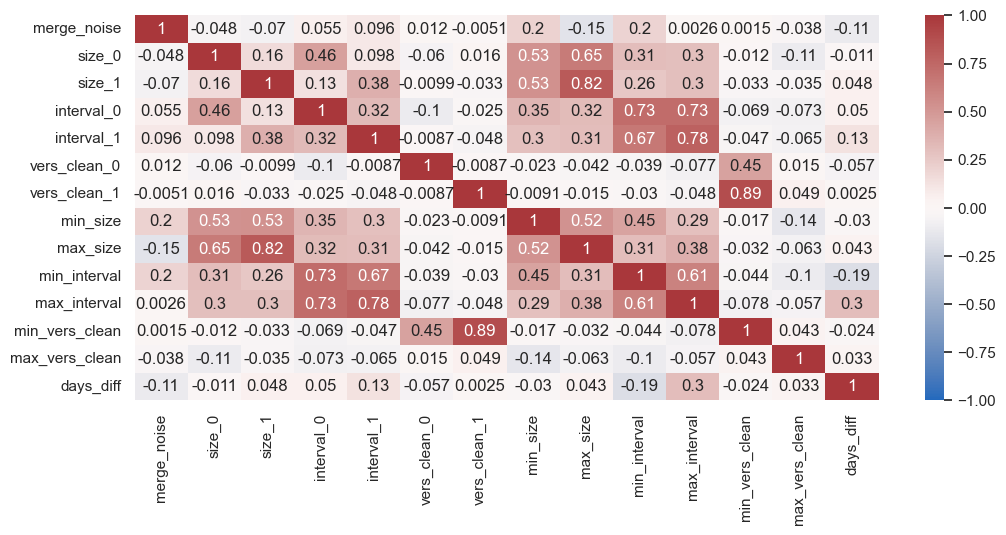

In [130]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [131]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [132]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

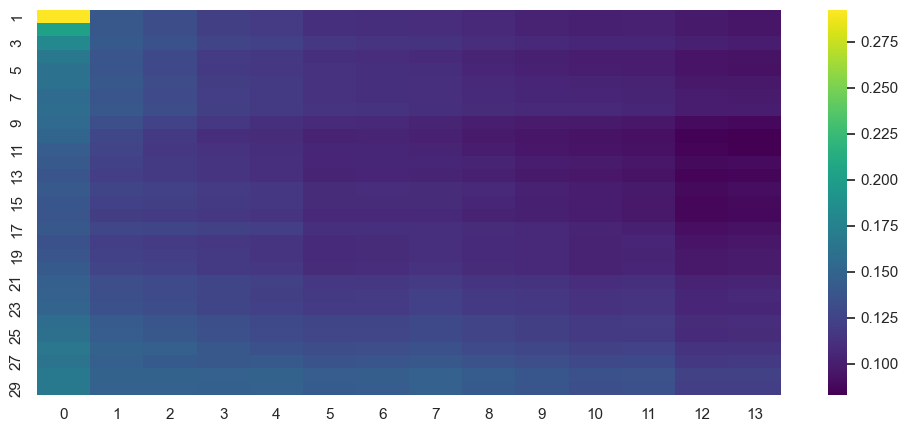

In [133]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

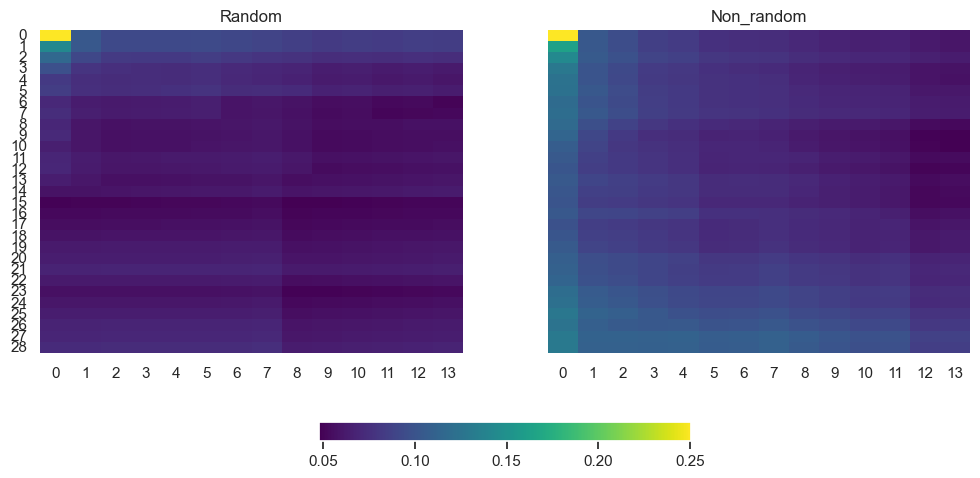

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [135]:
ratio_matrix = 1 - np.divide(matrix, matrix2)

<AxesSubplot: >

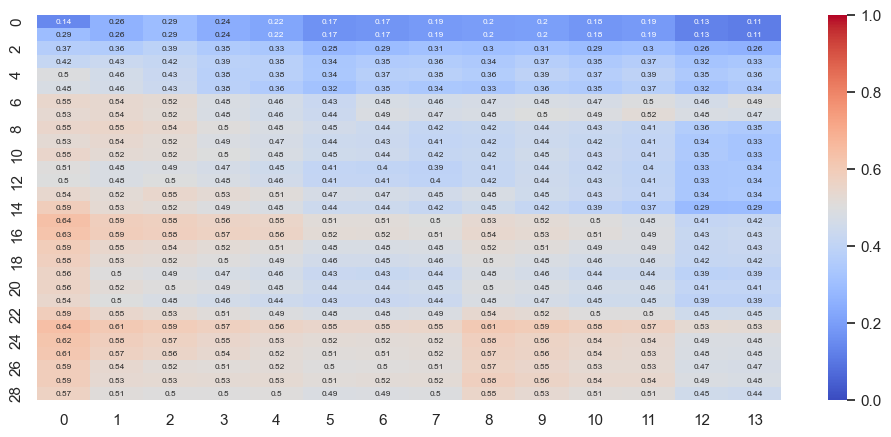

In [136]:
sns.heatmap(ratio_matrix, cmap='coolwarm', vmin=0, vmax=1, annot=True, annot_kws={'fontsize': 6})

#### GridSearch

In [137]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 15000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [138]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [139]:
results_df.sort_values(by='ratio', ascending=False).head(10)

min_interval  min_size  min_vers_clean  merge_noise    random  \
2725              1         9        0.722222         0.02  0.059761   
14996             1         9        0.722222         0.02  0.059761   
7927              1         9        0.611111         0.02  0.059761   
7918              1         9        0.666667         0.02  0.059761   
5798              1         9        0.611111         0.02  0.059761   
8196              1         9        0.500000         0.02  0.059761   
2782              0         9        0.777778         0.02  0.069597   
9257              0         9        0.833333         0.02  0.069597   
9043              0         9        0.777778         0.02  0.069597   
4843              0         9        0.611111         0.02  0.069597   

       non-random  difference     ratio  
2725     0.133333    0.073572  0.551793  
14996    0.133333    0.073572  0.551793  
7927     0.133333    0.073572  0.551793  
7918     0.133333    0.073572  0.551793  
5798     0.133333    0.073572  0.551793  
8196     0.133333    0.073572  0.551793  
2782     0.154562    0.084965  0.549715  
9257     0.154562    0.084965  0.549715  
9043     0.154562    0.084965  0.549715  
4843     0.154275    0.084678  0.548877

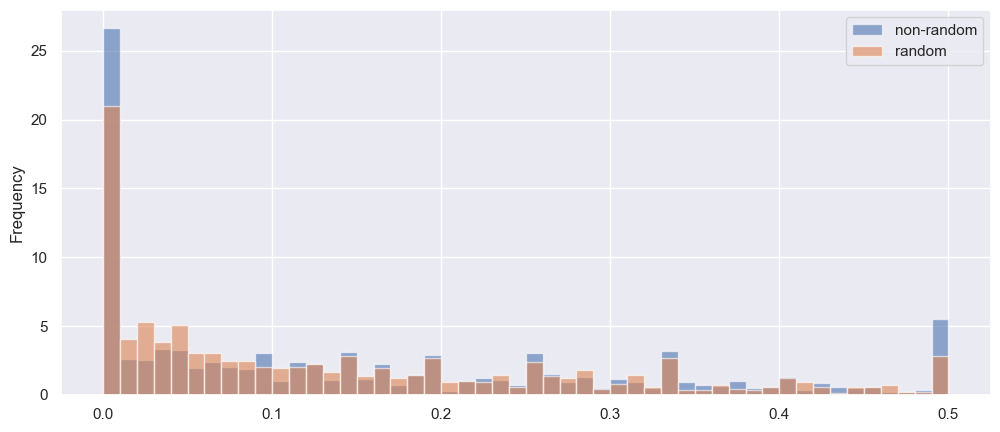

In [189]:
random_trial_data2.loc[random_trial_data2['min_size']>0, 'merge_noise'].plot.hist(bins=50, alpha=0.6, density=True)
random_trial_data.loc[random_trial_data['min_size']>0, 'merge_noise'].plot.hist(bins=50, alpha=0.6, density=True)
plt.legend(['non-random', 'random'])

In [161]:
results_df.iloc[results_df['ratio'].idxmin()]

min_interval      13.000000
min_size           2.000000
min_vers_clean     1.000000
merge_noise        0.080000
random             0.296928
non-random         0.247951
difference         0.048978
ratio             -0.197529
Name: 912, dtype: float64

In [140]:
results_df[(results_df['min_size']<=7) 
           & (results_df['min_interval']<=7)].sort_values(by='ratio', ascending=False).head(10)

min_interval  min_size  min_vers_clean  merge_noise    random  \
11780             0         7        0.888889         0.02  0.070769   
2344              0         7        0.888889         0.02  0.070769   
12010             0         7        0.833333         0.02  0.070552   
5373              0         7        0.722222         0.02  0.070552   
11525             0         7        0.722222         0.02  0.070552   
4381              0         7        0.555556         0.02  0.070552   
7682              1         7        0.888889         0.02  0.063973   
11719             1         7        0.777778         0.02  0.063758   
8164              1         7        0.777778         0.02  0.063758   
665               1         7        0.777778         0.02  0.063758   

       non-random  difference     ratio  
11780    0.156051    0.085282  0.546499  
2344     0.156051    0.085282  0.546499  
12010    0.155309    0.084757  0.545731  
5373     0.155063    0.084511  0.545011  
11525    0.155063    0.084511  0.545011  
4381     0.155063    0.084511  0.545011  
7682     0.138632    0.074659  0.538541  
11719    0.137868    0.074109  0.537539  
8164     0.137868    0.074109  0.537539  
665      0.137868    0.074109  0.537539

<AxesSubplot: xlabel='non-random', ylabel='ratio'>

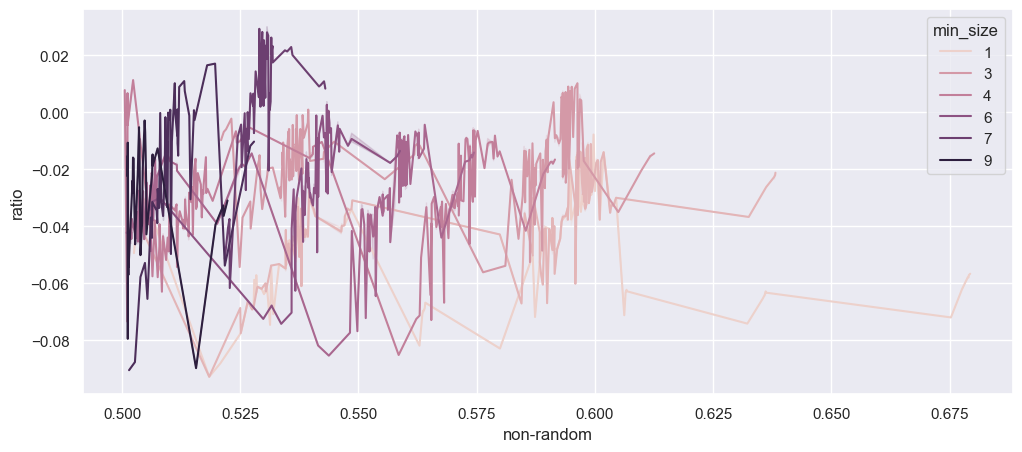

In [141]:
sns.lineplot(data=results_df.loc[results_df['non-random']>0.5], x='non-random', y='ratio', 
            hue='min_size')

In [142]:
cuts = results_df.copy()
cuts['non-random_cut'] = pd.cut(cuts.loc[cuts['non-random']>0.5, 'non-random'], 20)
cuts['nr_mid_cut'] = cuts['non-random_cut'].apply(lambda i:i.mid)

<AxesSubplot: xlabel='nr_mid_cut', ylabel='ratio'>

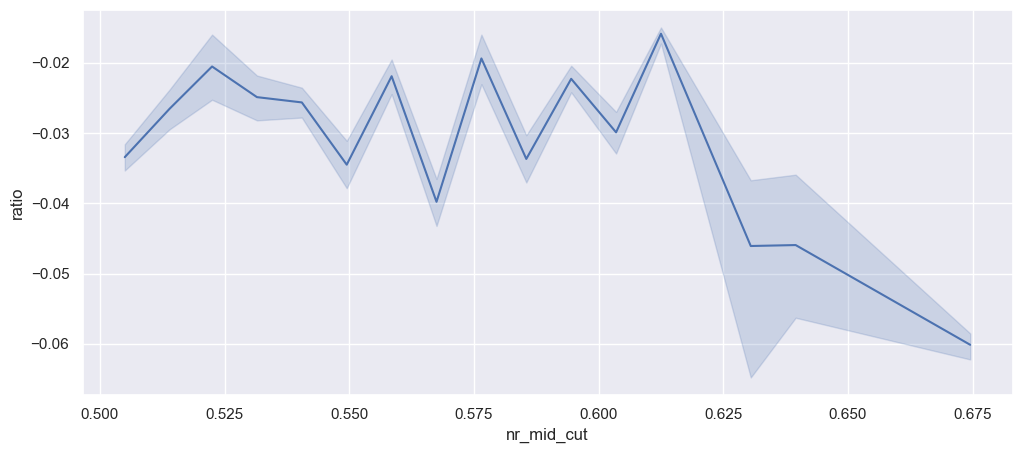

In [143]:
sns.lineplot(data=cuts, x='nr_mid_cut', y='ratio')#, hue='min_size')

<AxesSubplot: xlabel='min_size', ylabel='ratio'>

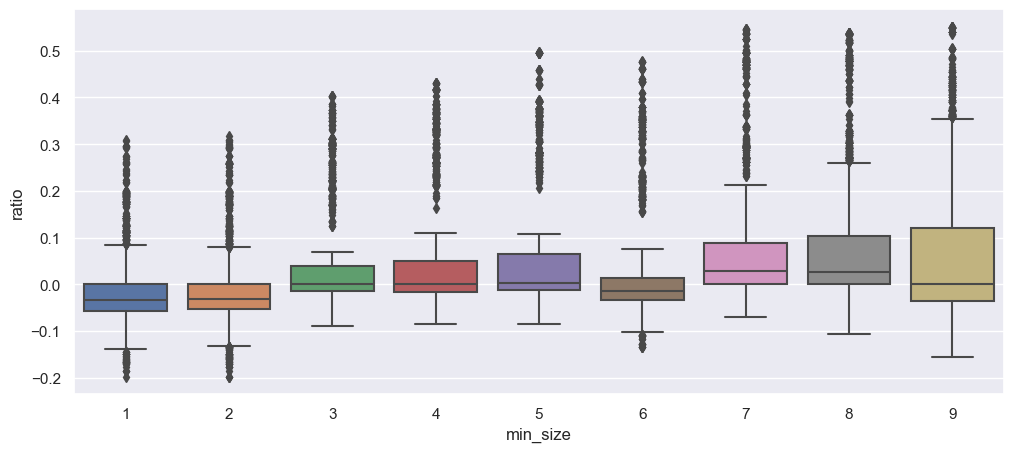

In [144]:
sns.boxplot(data=results_df, y='ratio', x='min_size')

## More features

- [X] Min interval
- [X] Max interval
- [X] Time between end first and start second (maybe after remove outliers)
- [ ] Time interval we looked at (can check options)
- [X] Min size
- [X] Max size
- [X] UA version error
- [X] Overlap errors that we calculate

### Wait a minute!

In [182]:
random_trial_data.head(1)

merge_noise  size_0  size_1               time_diff       first  \
0          0.0      77       6 27 days 09:33:45.099000  IUjkGRKgxd   

       second                 start_0                   end_0  interval_0  \
0  gUlQWbXrL9 2022-12-02 09:48:10.154 2022-12-10 18:00:06.486           8   

                  start_1  ... interval_1  vers_clean_0  vers_clean_1  \
0 2022-12-29 19:21:55.253  ...         57           1.0           1.0   

   min_size  max_size  min_interval  max_interval  min_vers_clean  \
0         6        77             8            57             1.0   

   max_vers_clean  days_diff  
0             1.0         27  

[1 rows x 21 columns]

In [184]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'
noise_thresh = 0.01

In [203]:
matrix_cum2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.7]).all(axis=1)]
        # good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(total_above_thresh))
    matrix_cum2.append(row)

In [204]:
matrix_cum2

[[884, 473, 450, 442, 428, 416, 404, 394, 386, 375, 369, 360, 353, 345],
 [621, 473, 450, 442, 428, 416, 404, 394, 386, 375, 369, 360, 353, 345],
 [518, 439, 422, 415, 402, 391, 380, 370, 363, 353, 347, 339, 332, 325],
 [452, 396, 385, 380, 370, 361, 351, 344, 337, 327, 322, 317, 312, 305],
 [403, 362, 354, 351, 343, 334, 326, 319, 313, 304, 299, 295, 291, 286],
 [367, 332, 324, 322, 316, 309, 302, 297, 291, 283, 280, 277, 273, 268],
 [326, 298, 290, 288, 284, 278, 272, 267, 261, 255, 252, 249, 245, 242],
 [300, 278, 270, 268, 266, 262, 257, 252, 246, 242, 239, 236, 232, 230],
 [273, 251, 245, 243, 241, 238, 235, 230, 224, 220, 217, 215, 211, 210],
 [252, 236, 231, 229, 227, 224, 221, 216, 210, 207, 204, 202, 198, 197],
 [231, 218, 213, 211, 209, 206, 203, 198, 192, 189, 186, 184, 180, 179],
 [217, 204, 199, 197, 195, 193, 191, 187, 181, 178, 176, 174, 170, 169],
 [201, 191, 186, 184, 182, 180, 179, 175, 169, 166, 164, 162, 159, 158],
 [186, 182, 179, 177, 175, 173, 172, 168, 162, 160,

In [192]:
total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [3, 1, 0.7]).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [3, 1, 0.7]).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.127129750982962
0.07061503416856492


In [211]:
sum(random_trial_data['min_size']>3)

453

In [251]:
random_cuts = random_trial_data2[random_trial_data2['min_size']<20].copy()
random_cuts['days_cut'] = pd.cut(random_cuts['days_diff'], 5)
random_cuts['size_cut'] = pd.qcut(random_cuts['min_size'], 4, duplicates='drop')
random_cuts['days_cut'] = random_cuts['days_cut'].apply(lambda i:i.mid)
random_cuts['size_cut'] = random_cuts['size_cut'].apply(lambda i:i.mid)

<AxesSubplot: xlabel='days_cut', ylabel='merge_noise'>

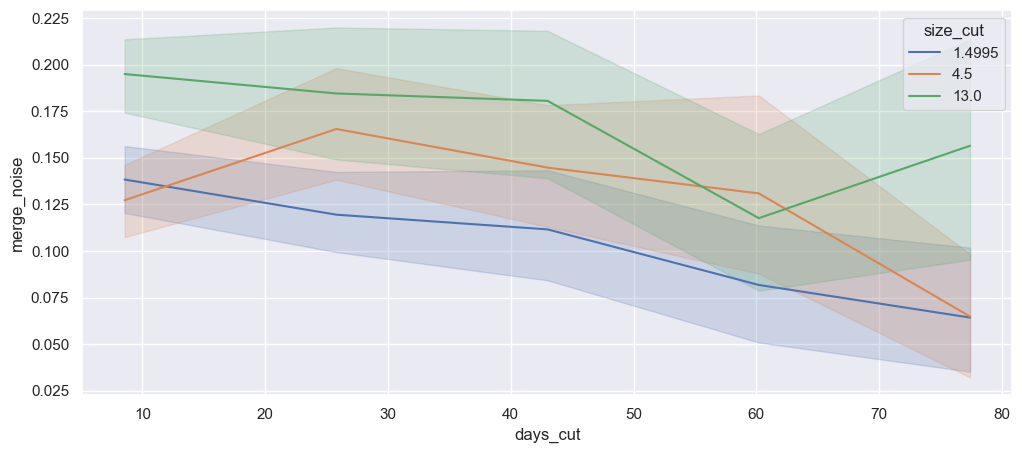

In [252]:
sns.lineplot(data=random_cuts, x='days_cut', y='merge_noise', hue='size_cut')

<AxesSubplot: ylabel='merge_noise'>

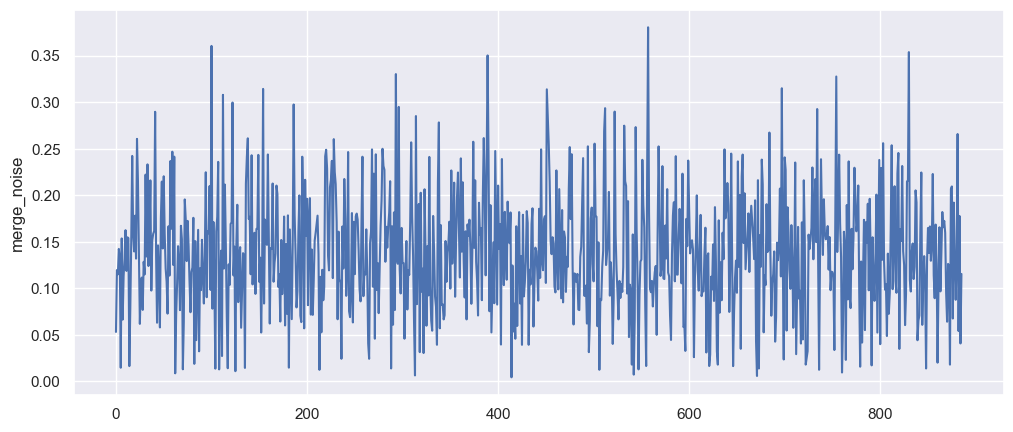

In [217]:
rolling = random_trial_data.sort_values(by='time_diff')['merge_noise'].rolling(5).mean()
sns.lineplot(data=rolling)

<AxesSubplot: xlabel='days_diff', ylabel='merge_noise'>

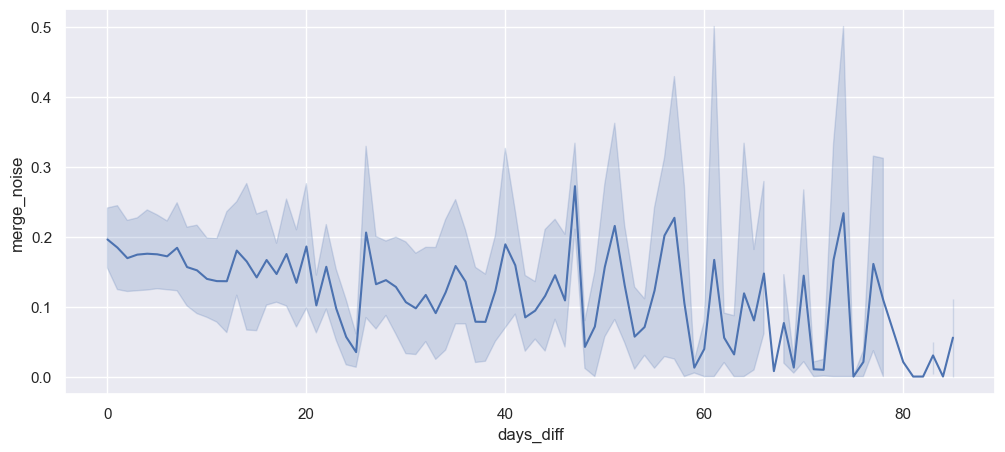

In [219]:

sns.lineplot(data=random_trial_data, x='days_diff', y='merge_noise', hue=')

In [199]:
len(random_trial_data2)

1734